# Russian death rates visualization
### What causes the death of different age groups?
---
Ilia Moiseev, 2020  

This notebook is based on the work that was done for publication in [ourcountryindata](https://ourcountryindata.ru/samye-chastye-prichiny-smerti-v-zavisimosti-ot-vozrasta-i-pola/) website and represents all the steps that I've got through when I worked on this project. The main question was like this in the title. What causes the death of different age groups? What trends we can explore now, what current data can tell us about the reasons of all fatal cases in our country? Here, in this notebook I describe the technical part of the question. Sort of **how** do we get answers, but not the answers itself.

## Contents:
1. [Data acquisition](#Acquiring)
2. [Preparation](#Preparation)  
    2.1 [Query formulation](#Query)
3. [Visualization](#Visualization)  
    3.1 [Name length problem](#Namelength)  
    3.2 [Creating some more reusable functions](#Creatingfunctions)  
    3.3 [Final version](#Finalversion)
4. [Conclusion (with final version)](#Conclusion)

# Acquiring the data <a name="Acquiring"></a>

To address the question from the title we need such data where we can see the number of deaths for a particular age group and particular cause.
Data that satisfy this condition were downloaded from this [repository](https://github.com/aremt/linked-social-data-ru), but the initial source is [here](http://demogr.nes.ru/en/demogr_indicat/data_description). In that repo we can find a table with death rates for a particular year and region per one million people.  
In this particular table we have death rates for years 2015-2018. 

# Preparing the data <a name="Preparation"></a>

Let's have a look at downloaded data. It is `.csv` files - values separated with ';'  
We need only two files for our research from mentioned repository:  
`deathRates.csv` - main table of death rates data with all information  
`deathRatesCauseDictionary.csv` - dictionary with different names of causes to place them on plots

We place files in the folder `./data`

In [114]:
import pandas as pd

data = pd.read_csv('./data/deathRates.csv', sep=';')
names = pd.read_csv(r'./data/deathRatesCauseDictionary.csv', sep=';', 
                    encoding='UTF-8') #we need UTF-8 encoding to properly handle Cyrillic characters

First five rows of main table are printed below.
What we can see: 
- Year of the record in `year` column
- Region ID in `regAliasDeathID`
- `area` column has three types of records: `T` stands for "Total", `R` stands for "Rural" and `U` stands for "Urban" in our research we interested only in "Total" data 
- `sex` represents gender group `M` for "Male" and `F` for "Female"
- ID of particular death cause in column `causeID`
- Number of deaths from 1 000 000 people of different age groups that represented in columns `0-85`. `0` represents newborns, `1` represents 1 - 4 years old people, `5` represents 5 - 9 years old and so on.

In [115]:
data.head()

,year,regAliasDeathID,area,sex,causeID,0,1,5,10,15,...,40,45,50,55,60,65,70,75,80,85
0,2015,1100,T,M,0,7329,420,260,319,972,...,8559,10810,14964,21351,31611,41546,58791,83221,118622,175102
1,2015,1100,T,M,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,1100,T,M,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,2
3,2015,1100,T,M,5,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2015,1100,T,M,6,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,5


Here we can see `names` table. It is dictionary for codes of death causes.  
Its columns:  
- `causeID` - similar to column in `data`
- `Название` - cause name written in Russian
- `Англ.название` - cause name written in English
-  `Входящие коды ICD10 *` - ICD-10 codes that are present in certain group ([ICD](https://en.wikipedia.org/wiki/ICD-10) is the 10th revision of the International Statistical Classification of Diseases and Related Health Problems)
- `Группа причин` - ICD code of causes group
- `Раздел МКБ-10` - ICD-10 chapter name written in Russian
- `Подраздел МКБ-10` - ICD-10 block name 
- `ГруппаMine` - some sort of custom column made for grouping causes
- `Короткое название` - short cause name (it is useful for visualization purposes)

In [116]:
names.head()

,causeID,Название,Англ.название,Входящие коды ICD10 *,Группа причин,Раздел МКБ-10,Подраздел МКБ-10,ГруппаMine,Короткое название
0,1,Холера,Cholera,A00,A,Некоторые инфекционные и паразитарные болезни,Кишечные инфекции,NaN,Холера
1,2,Брюшной тиф,Typhoid fever,A010,A,Некоторые инфекционные и паразитарные болезни,Кишечные инфекции,NaN,Брюшной тиф
2,3,Паратифы,Paratyphoid fever,"A011,A012,A013,A014",A,Некоторые инфекционные и паразитарные болезни,Кишечные инфекции,NaN,Паратифы
3,4,Другие сальмонеллезные инфекции,Other salmonella infections,A02,A,Некоторые инфекционные и паразитарные болезни,Кишечные инфекции,NaN,Другие сальмонеллезные инфекции
4,5,Шигеллез,Shigellosis,A03,A,Некоторые инфекционные и паразитарные болезни,Кишечные инфекции,NaN,Шигеллез


Let's properly name columns of our tables and merge them to form one table with all the data we need.

In [117]:
data = data.rename(columns={
    'regAliasDeathID':'region_id',
    'causeID':'cause_id'
})

names = names.rename(columns={
    'causeID':'cause_id',
    'Название':'name_rus',
    'Англ.название':'name_en',
    'Входящие коды ICD10 *':'ICD_codes',
    'Группа причин':'cause_group',
    'Раздел МКБ-10':'ICD10_chapter',
    'Подраздел МКБ-10':'ICD10_block',
    'ГруппаMine':'custom_group',
    'Короткое название':'name_rus_short'
})

In [118]:
data = data.merge(names)
data.head()

,year,region_id,area,sex,cause_id,0,1,5,10,15,...,80,85,name_rus,name_en,ICD_codes,cause_group,ICD10_chapter,ICD10_block,custom_group,name_rus_short
0,2015,1100,T,M,3,0,0,0,0,0,...,0,0,Паратифы,Paratyphoid fever,"A011,A012,A013,A014",A,Некоторые инфекционные и паразитарные болезни,Кишечные инфекции,NaN,Паратифы
1,2015,1100,T,F,3,0,0,0,0,0,...,0,0,Паратифы,Paratyphoid fever,"A011,A012,A013,A014",A,Некоторые инфекционные и паразитарные болезни,Кишечные инфекции,NaN,Паратифы
2,2015,1100,U,M,3,0,0,0,0,0,...,0,0,Паратифы,Paratyphoid fever,"A011,A012,A013,A014",A,Некоторые инфекционные и паразитарные болезни,Кишечные инфекции,NaN,Паратифы
3,2015,1100,R,F,3,0,0,0,0,0,...,0,0,Паратифы,Paratyphoid fever,"A011,A012,A013,A014",A,Некоторые инфекционные и паразитарные болезни,Кишечные инфекции,NaN,Паратифы
4,2015,33,T,M,3,0,0,0,0,0,...,0,0,Паратифы,Paratyphoid fever,"A011,A012,A013,A014",A,Некоторые инфекционные и паразитарные болезни,Кишечные инфекции,NaN,Паратифы


### Query formulation <a name="Query"></a>

Now we have to formulate our query to this table. What do we need to know?  
Let's say that we need to find out what are the top-10 causes for females in age group from 15 to 19 year old. We also have to specify the year from 2015 to 2018 and the type of the area. We would consider 2018 as the closest to current year (2020) and "Total" area type for more general results.  
However, do we need to sum all regions values to get the picture for the country? Yes, but seems that this table kind of did it for us - we have region with code `643` which represents the whole country.  
    
We also should mention what causes and causes groups we should **exclude** from the query. It appears that if we have for example death record and the cause was suicide by head injury, we consider cause as the suicide and also consider this record to appear in bigger category - "Injury, poisoning and certain other consequences of external causes". It means that in ICD-10 we count some fatal cases twice - in `S` and`T` group as a localization of trauma and more specific cause in `V`, `W`, `X`, `Y` groups. To achive more informative output without redundant data, we exclude ICD-10 categories `T` and `S` from our query.  
In addition to that we have `cause_id` that equals 0. According to table metadata meaning of this category is unknown and it doesn't appear in ICD-10 documentation, so we wouldn't regard this cause too.
  
Considering all of this lets write the query:

In [119]:
#we specify the parameters we are interested in:
group = 15
sex = 'F'
year = 2018
area = 'T'
region = 643

#we retrieve rows that satisfy selected parameters
#and sort them in descending order by the column that represents chosen age group
#picking after that top-10 values
data.loc[
    (data.region_id==region)&
    (data.sex==sex)&
    (data.area==area)&
    (data.year==year)&
    (data.cause_group!='T')&
    (data.cause_group!='S')&
    (data.cause_id!=0)].sort_values(str(group), ascending=False)[:10]

,year,region_id,area,sex,cause_id,0,1,5,10,15,...,80,85,name_rus,name_en,ICD_codes,cause_group,ICD10_chapter,ICD10_block,custom_group,name_rus_short
365672,2018,643,T,F,284,0,0,0,13,46,...,98,150,Другие преднамеренные самоповреждения (включая...,Other iIntentional self-harm,"X60-X64,X66-X84",X,Внешние причины заболеваемости и смертности,Преднамеренное самоповреждение,Самоубийства,Другие преднамеренные самоповреждения (включая...
329856,2018,643,T,F,258,19,11,10,10,42,...,16,11,"Лицо, находившееся в автотранспортном средстве...",The person that was found in the vehicle injur...,"V404-9,V414-9,V424-9,V434- 9,V444-9,V454-9,V46...",V,Внешние причины заболеваемости и смертности,Транспортные несчастные случаи,Неумышленные,"Лицо, находившееся в машине, пострадавшее в ре..."
384533,2018,643,T,F,295,0,5,1,9,20,...,30,72,"Падение, прыжок или сталкивание с высоты с нео...","Falling, jumping or pushed from a high place, ...",Y30,Y,Внешние причины заболеваемости и смертности,Повреждение с неопределенными намерениями,ПНН,"Падение, прыжок или сталкивание с высоты с нео..."
376115,2018,643,T,F,290,25,0,1,3,16,...,36,59,"Повешение, удушение и удавление с неопределенн...","Hanging, strangulation and suffocation, undete...",Y20,Y,Внешние причины заболеваемости и смертности,Повреждение с неопределенными намерениями,ПНН,"Повешение, удушение и удавление с неопределенн..."
124144,2018,643,T,F,117,90,28,11,11,13,...,6829,18054,Прочие нарушения нервной системы,Other disorders of the nervous system,"G10-G12,G14,G23- G25,G310,1,8,9,G36,G37,G43- G...",G,Болезни нервной системы,NaN,NaN,Прочие нарушения нервной системы
118036,2018,643,T,F,112,3,6,8,14,11,...,0,2,Детский Церебральный паралич,Infantile cerebral palsy,G80,G,Болезни нервной системы,NaN,NaN,Детский Церебральный паралич
301702,2018,643,T,F,244,65,9,6,11,11,...,634,657,Другие виды внезапной смерти по неизвестной пр...,"Other sudden death, cause unknown and unattend...",R96-R99,R,"Симптомы, признаки и отклонения от нормы, выяв...",NaN,NaN,Другие виды внезапной смерти по неизвестной пр...
367922,2018,643,T,F,285,5,5,3,3,11,...,33,28,"Убийство (нападение, насилие) совершенное друг...",Homicide and injury purposely inflicted by oth...,X85-Y09,X,Внешние причины заболеваемости и смертности,Нападение,Убийства,"Убийство, совершенное другим человеком"
325923,2018,643,T,F,256,1,3,3,8,10,...,64,32,"Пешеход, получивший травму в результате дорожн...",Pedestrian injured in road traffic cases (exce...,"V011,V021,V031,V041,V092- 3,V832,V842,V852,V862",V,Внешние причины заболеваемости и смертности,Транспортные несчастные случаи,Неумышленные,"Пешеход, получивший травму в результате ДТП (к..."
163639,2018,643,T,F,140,43,5,1,3,8,...,1194,2081,Прочие болезни сердца,Other forms of heart disease,"I30-I41,I420-5,7,8,I43- I45,I460,9,I47-I49,I50...",I,Болезни системы кровообращения,NaN,NaN,Прочие болезни сердца


These are interesting results. We can now change the parameters of given query and get results for different years, age groups and regions.  
But we want to summarize this statistics for all of the people within age group. It means that we want to have a comparison with the other gender groups. Top-10 causes for different gender groups are different as well, so we still should have two types of plots.  
How should we change our query now?  
We need to add new rows to resulting table. For each cause from our top that we acquired we need to extract same data but for different gender group.  
Let's see how it looks like.

In [120]:
#we do the same thing as before
group = 15
sex = 'F'
year = 2018
area = 'T'
region = 643

#we determine the opposite gender group
if(sex == 'M'):
    opp_sex = 'F'
else:
    opp_sex = 'M'

top = data.loc[
    (data.region_id==region)&
    (data.sex==sex)&
    (data.area==area)&
    (data.year==year)&
    (data.cause_group!='T')&
    (data.cause_group!='S')&
    (data.cause_id!=0)].sort_values(str(group), ascending=False)[:10]

#but this time for each cause in given top we retrieve information for other gender and add it to our result
for cause in top.cause_id:
    top = top.append(data.loc[
        (data.region_id==region)&
        (data.sex==opp_sex)&
        (data.area==area)&
        (data.year==year)&
        (data.cause_group!='T')&
        (data.cause_group!='S')&
        (data.cause_id==cause)]
        )
top

,year,region_id,area,sex,cause_id,0,1,5,10,15,...,80,85,name_rus,name_en,ICD_codes,cause_group,ICD10_chapter,ICD10_block,custom_group,name_rus_short
365672,2018,643,T,F,284,0,0,0,13,46,...,98,150,Другие преднамеренные самоповреждения (включая...,Other iIntentional self-harm,"X60-X64,X66-X84",X,Внешние причины заболеваемости и смертности,Преднамеренное самоповреждение,Самоубийства,Другие преднамеренные самоповреждения (включая...
329856,2018,643,T,F,258,19,11,10,10,42,...,16,11,"Лицо, находившееся в автотранспортном средстве...",The person that was found in the vehicle injur...,"V404-9,V414-9,V424-9,V434- 9,V444-9,V454-9,V46...",V,Внешние причины заболеваемости и смертности,Транспортные несчастные случаи,Неумышленные,"Лицо, находившееся в машине, пострадавшее в ре..."
384533,2018,643,T,F,295,0,5,1,9,20,...,30,72,"Падение, прыжок или сталкивание с высоты с нео...","Falling, jumping or pushed from a high place, ...",Y30,Y,Внешние причины заболеваемости и смертности,Повреждение с неопределенными намерениями,ПНН,"Падение, прыжок или сталкивание с высоты с нео..."
376115,2018,643,T,F,290,25,0,1,3,16,...,36,59,"Повешение, удушение и удавление с неопределенн...","Hanging, strangulation and suffocation, undete...",Y20,Y,Внешние причины заболеваемости и смертности,Повреждение с неопределенными намерениями,ПНН,"Повешение, удушение и удавление с неопределенн..."
124144,2018,643,T,F,117,90,28,11,11,13,...,6829,18054,Прочие нарушения нервной системы,Other disorders of the nervous system,"G10-G12,G14,G23- G25,G310,1,8,9,G36,G37,G43- G...",G,Болезни нервной системы,NaN,NaN,Прочие нарушения нервной системы
118036,2018,643,T,F,112,3,6,8,14,11,...,0,2,Детский Церебральный паралич,Infantile cerebral palsy,G80,G,Болезни нервной системы,NaN,NaN,Детский Церебральный паралич
301702,2018,643,T,F,244,65,9,6,11,11,...,634,657,Другие виды внезапной смерти по неизвестной пр...,"Other sudden death, cause unknown and unattend...",R96-R99,R,"Симптомы, признаки и отклонения от нормы, выяв...",NaN,NaN,Другие виды внезапной смерти по неизвестной пр...
367922,2018,643,T,F,285,5,5,3,3,11,...,33,28,"Убийство (нападение, насилие) совершенное друг...",Homicide and injury purposely inflicted by oth...,X85-Y09,X,Внешние причины заболеваемости и смертности,Нападение,Убийства,"Убийство, совершенное другим человеком"
325923,2018,643,T,F,256,1,3,3,8,10,...,64,32,"Пешеход, получивший травму в результате дорожн...",Pedestrian injured in road traffic cases (exce...,"V011,V021,V031,V041,V092- 3,V832,V842,V852,V862",V,Внешние причины заболеваемости и смертности,Транспортные несчастные случаи,Неумышленные,"Пешеход, получивший травму в результате ДТП (к..."
163639,2018,643,T,F,140,43,5,1,3,8,...,1194,2081,Прочие болезни сердца,Other forms of heart disease,"I30-I41,I420-5,7,8,I43- I45,I460,9,I47-I49,I50...",I,Болезни системы кровообращения,NaN,NaN,Прочие болезни сердца


This is great results, but it is unclear and difficult to understand. Our next step is to visualize them.

## Visualizing the data <a name="Visualization"></a>  
Let's do some simple visualisation of our results. We would use `seaborn` library as the most convenient way to build basic visualizations and some of `matplotlib` to fine-tune the plot.  
  
As the first look I want to try to create some barplot with each bar representing each cause in the same descending order. We want actually two bars for one particular cause - one for each gender group.  

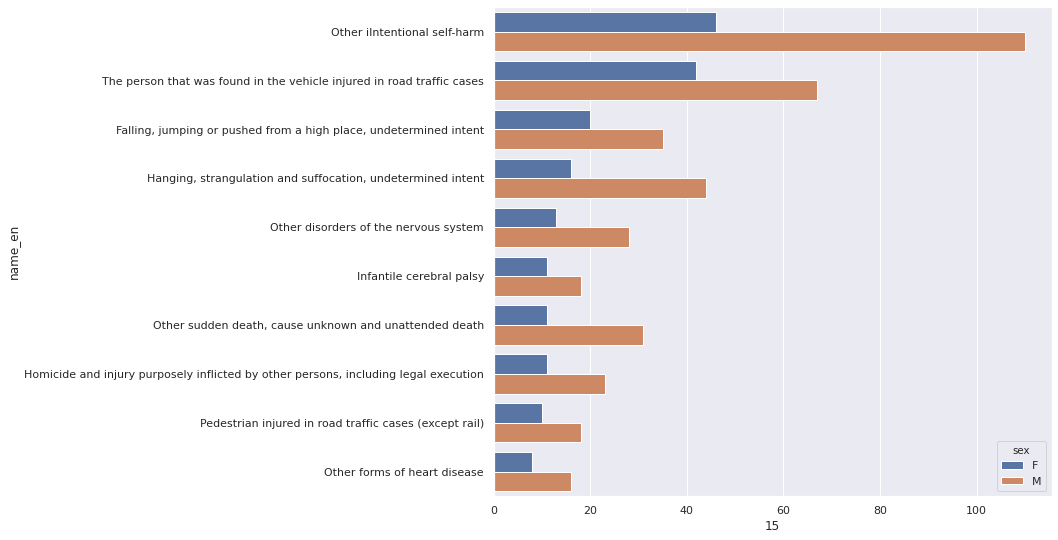

In [121]:
import seaborn as sns
from matplotlib import pyplot as plt

#define matplotlib figure and axes
f, ax = plt.subplots(figsize=(10,9))

#and place our barplot on them
sns.barplot( 
    x=str(group), 
    y='name_en',
    data=top , 
    hue='sex', 
    orient='h',
    ax=ax)

This is more informative than raw data we saw in table, but still not enough for anyone who isn't familiar with the data itself.  
- Axes have no understandable names - only the ones that we gave, they were convenient for programming reasons and now ought to be replaced
- Figure has no title either
- Font size can be pretty small, especially if cause names are very long (we also need more fashionable font)
- Bar colors wouldn't change if we change gender group, that could cause misunderstanding, colors should be consistent with presented data (and also more bright and contrasting making it easier for colorblind people to discern)

We can come up with different color palette that would consistent with data:

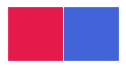

In [122]:
colors = []
if(sex == 'M'):
    colors = ["#4363d8", "#e6194B"]
else:
    colors = ["#e6194B", "#4363d8"]
sns.palplot(colors)

In [130]:
#we make the title, subtitle and subtext on the bottom with credentials and additional information
#information in titles changes automatically considering the data
sns.set(font_scale=1)
title = '10 most frequent death causes'
axtitle = ''
if (sex == 'M'):
    axtitle = 'Males ' 
else:
    axtitle = 'Females '    

#this is special cases
if(group == 0):
    axtitle += '0 - 1 year old'
elif(group == 85):
    axtitle += '85 years old and older'
else:
    axtitle += str(group) + '-' + str(group+4) + ' years old'

subtext = '''The number of fatal cases in Russia per 1 million people of given age and sex during 2018. Death causes classification - ICD-10.\nAnother gender group is given for comparison.\nData: CDR NES. Graphics: Ilia Moiseev. Publication: Россия в данных | OurCountryInData.ru'''

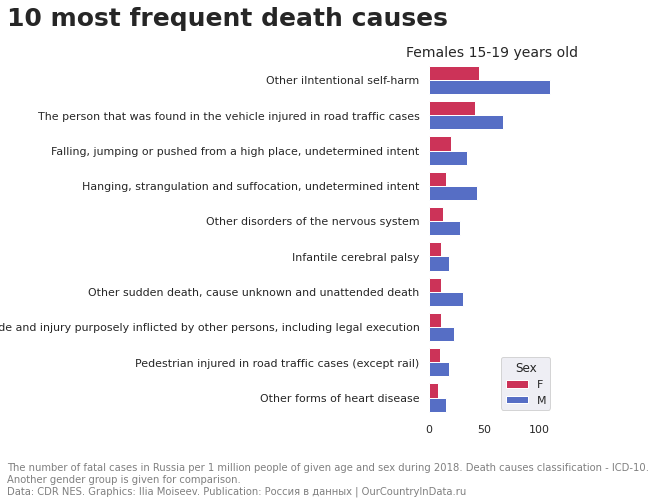

In [124]:
f, ax = plt.subplots(figsize=(8,7))
sns.barplot(
    y='name_en', 
    x=str(group), 
    data=top , 
    hue='sex', 
    orient='h', 
    palette=sns.color_palette(colors),
    ax=ax)
plt.tight_layout()
plt.rcParams['font.sans-serif']=['SF Pro Display Regular']

#we move the plot boundaries
plt.subplots_adjust(top=0.87)
plt.subplots_adjust(bottom=0.17)

#all the values were found by trial and error to achieve better view
plt.suptitle(title, x = 0.025, y = 0.98, fontsize=25, horizontalalignment='left', fontweight='bold')
plt.figtext(0.025, 0.013, subtext, fontsize=10, color='grey')
ax.set_title(axtitle, fontsize=14)

#we add legend, remove axis labels and frame
ax.legend(loc='lower right', title = 'Sex')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_frame_on(False)
plt.show()

### Name length problem <a name="Namelength"></a>
Now that's a nice-looking plot! But what's wrong?  
We can see cause name (third one from bottom) that is so long it crushes through the boundaries.  
We definitely need to address this issue since I haven't found a way to brake long lines automatically with the tools of `matplotlib`.  
Let's see how long are cause names in general.

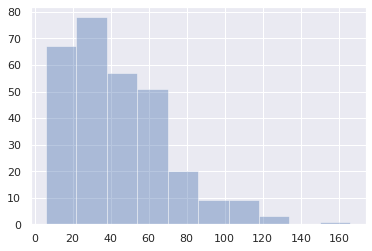

In [125]:
#we form the table with only unique name lengths to see it's actual distribution
name_lengths = [len(name) for name in data.name_en.unique()]
sns.distplot(name_lengths, bins = 10, kde=False)

Well, the most of the names aren't that big, but there are actually small fraction of very long ones. We can't get rid of them or leave them this way.  
At least now we know what we are working with.  
I decided to address this problem in somewhat unusual way. I've wrote a function that places line endings `\n` between words if name is long enough. It is simple euristic-like approach, but it works well on data and quite reusable.

In [131]:
from math import ceil

def add_endlines(name):
    length = len(name)
    words = name.split()
    wordsLen = len(words)
    
    #the number of parts into which we will divide the name
    parts = 0
    if(length > 30 and length <= 70):
        parts = 2
    elif(length > 70 and length <= 140):
         parts = 3
    elif(length > 130):
        parts = 4
    #we don't need to divide short names
    if(parts == 0):
        return name

    #here we get indexes where to put line breaks and then add them
    idxs = []
    for i in range(0, wordsLen, ceil(wordsLen / parts)):
        idxs.append(i)

    newname = ''
    for i in range(wordsLen):
        if(idxs.count(i) != 0):
            newname+='\n'
        newname += words[i] + ' '
    return newname

### Creating some more reusable functions  <a name="Creatingfunctions"></a>

But before another try let's make it easier to make plots by making simple functions for it.  
To not to mix up querying and visualization we actually need two functions:
- the one that would return query results
- and the other that would visualize results  
  
We would use all the code given before to write them.

In [133]:
#we broadened applications of our function by adding parameter top that allowes us to create top-N's instead of only top-10's
def query_top(data, age_group, sex, year, area, region, top=10):
    if(sex == 'M'):
        opp_sex = 'F'
    else:
        opp_sex = 'M'

    top = data.loc[
        (data.region_id==region)&
        (data.sex==sex)&
        (data.area==area)&
        (data.year==year)&
        (data.cause_group!='T')&
        (data.cause_group!='S')&
        (data.cause_id!=0)].sort_values(str(age_group), ascending=False)[:top]

    for cause in top.cause_id:
        top = top.append(data.loc[
            (data.region_id==region)&
            (data.sex==opp_sex)&
            (data.area==area)&
            (data.year==year)&
            (data.cause_group!='T')&
            (data.cause_group!='S')&
            (data.cause_id==cause)]
            )
    return top

def show_barplot(query_data, top=10):
    sns.set(font_scale=1)
    title = str(top) + ' most frequent death causes'
    axtitle = ''
    if (sex == 'M'):
        axtitle = 'Males ' 
    else:
        axtitle = 'Females '    

    if(group == 0):
        axtitle += '0 - 1 years old'
    elif(group == 85):
        axtitle += '85 years old and older'
    else:
        axtitle += str(group) + '-' + str(group+4) + ' years old'

    subtext = '''The number of fatal cases in Russia per 1 million people of given age and sex during 2018. Death causes classification - ICD-10.\nAnother gender group is given for comparison.\nData: CDR NES. Graphics: Ilia Moiseev. Publication: Россия в данных | OurCountryInData.ru'''
    
    f, ax = plt.subplots(figsize=(8,7))
    sns.barplot(
        y='name_en', 
        x=str(group), 
        data=query_data, 
        hue='sex', 
        orient='h', 
        palette=sns.color_palette(colors),
        ax=ax)

    plt.tight_layout()

    plt.rcParams['font.sans-serif']=['SF Pro Display Regular']

    plt.subplots_adjust(top=0.87)
    plt.subplots_adjust(bottom=0.17)

    plt.suptitle(title, x = 0.025, y = 0.98, fontsize=25, horizontalalignment='left', fontweight='bold')
    plt.figtext(0.025, 0.013, subtext, fontsize=10, color='grey')
    ax.set_title(axtitle, fontsize=14)
    ax.legend(loc='lower right', title = 'Sex')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_frame_on(False)
    plt.show()

### Final version <a name="Finalversion"> </a>
So now when we are all set, let's brake the names into parts and use functions to get new plot.

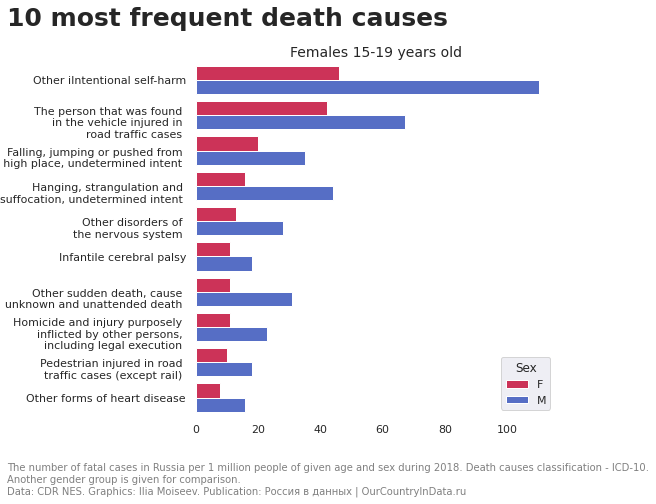

In [134]:
data.name_en = data.name_en.apply(add_endlines)

group = 15
sex = 'F'
year = 2018
area = 'T'
region = 643

show_barplot(query_top(data, group, sex, year, area, region))

## Conclusion
Now it looks more informative and visually attractive. I consider my mission complete by this moment. However, what's with the initial question? What are the main reasons of death for different age and sex groups?  
Now we can easily answer it, based on the data! I can't overload this work and post all plots here, but all the plots were posted on [ourcountryindata](https://ourcountryindata.ru/samye-chastye-prichiny-smerti-v-zavisimosti-ot-vozrasta-i-pola/) website (only in Russian, contact me <villeman.5@yandex.ru> if you want to see English version of the plots or you could use the data and code above to generate them by yourself). I would also appreciate any feedback.